In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

idx = pd.IndexSlice

scenario = "LW"
ll = "hnd"

data = pd.read_csv(
    Path.cwd().parent / 
    "results" / 
    "pypsa-fes" /
    "csvs" /
    # "flex_statistics_combined.csv",
    "flex_statistics.csv",
    index_col=[0,1],
    header=[0,1,2,3,4]
    )

data = data.loc[:, idx[ll, :, :, scenario, :]]
data.columns = data.columns.droplevel([0,1,3])

cols = data.columns.to_frame()
cols.loc[cols["flexopts"].str.contains("Unnamed"), "flexopts"] = "no flex"

data.columns = pd.MultiIndex.from_frame(cols)

data = data.loc[:, idx[["no flex", "int-tank-ss-v2g"]]]

c1 = "#FF0659"
c2 = "#008BFB"

intermittent = pd.Index(["solar", "onwind", "offwind-ac", "offwind-dc"])
conventional = pd.Index(["OCGT", "CCGT", "nuclear", "biomass", "allam"])

In [2]:
data

flexopts                            no flex                               \
year                                   2025          2030           2035   
GB0 Z10 OCGT_energy                0.000000      0.000000       0.000000   
        CCGT_energy                0.000000      0.000000       0.000000   
        allam_energy              12.364976  24479.421881  121557.885472   
        nuclear_energy             0.000000      0.000000       0.000000   
        modular nuclear_energy     0.000000      0.000000       0.000000   
...                                     ...           ...            ...   
GB0 Z9  OCGT_p_nom                80.668730     47.674690      15.761037   
        CCGT_p_nom              4802.094284   2838.006183     938.232034   
        allam_p_nom                0.003050      2.894585    1180.768388   
        nuclear_p_nom              0.000000      0.000000       0.000000   
        biomass_p_nom            412.400000    412.400000     412.400000   

flexopts                                                                  \
year                                    2040          2045          2050   
GB0 Z10 OCGT_energy             0.000000e+00  0.000000e+00  0.000000e+00   
        CCGT_energy             0.000000e+00  0.000000e+00  0.000000e+00   
        allam_energy            1.782208e+06  2.565446e+06  2.713287e+06   
        nuclear_energy          0.000000e+00  0.000000e+00  0.000000e+00   
        modular nuclear_energy  0.000000e+00  0.000000e+00  0.000000e+00   
...                                      ...           ...           ...   
GB0 Z9  OCGT_p_nom              0.000000e+00  0.000000e+00  0.000000e+00   
        CCGT_p_nom              0.000000e+00  0.000000e+00  0.000000e+00   
        allam_p_nom             2.246153e+03  2.003497e+03  1.334983e+03   
        nuclear_p_nom           0.000000e+00  0.000000e+00  0.000000e+00   
        biomass_p_nom           4.124000e+02  4.124000e+02  4.124000e+02   

flexopts                       int-tank-ss-v2g                           \
year                                      2025         2030        2035   
GB0 Z10 OCGT_energy                   0.000000     0.000000    0.000000   
        CCGT_energy                   0.000000     0.000000    0.000000   
        allam_energy                  8.056220     7.725979  933.272841   
        nuclear_energy                0.000000     0.000000    0.000000   
        modular nuclear_energy        0.000000     0.000000    0.000000   
...                                        ...          ...         ...   
GB0 Z9  OCGT_p_nom                   80.668730    47.674690   15.761037   
        CCGT_p_nom                 4802.094284  2838.006183  938.232034   
        allam_p_nom                   0.002226     0.002549    0.081152   
        nuclear_p_nom                 0.000000     0.000000    0.000000   
        biomass_p_nom               412.400000   412.400000  412.400000   

flexopts                                                                    
year                                     2040           2045          2050  
GB0 Z10 OCGT_energy                  0.000000       0.000000      0.000000  
        CCGT_energy                  0.000000       0.000000      0.000000  
        allam_energy            290289.571824  229403.740125  88988.847005  
        nuclear_energy               0.000000       0.000000      0.000000  
        modular nuclear_energy       0.000000       0.000000      0.000000  
...                                       ...            ...           ...  
GB0 Z9  OCGT_p_nom                   0.000000       0.000000      0.000000  
        CCGT_p_nom                   0.000000       0.000000      0.000000  
        allam_p_nom                 40.030631     586.624001    854.395223  
        nuclear_p_nom                0.000000       0.000000      0.000000  
        biomass_p_nom              412.400000     412.400000    412.400000  

[459 rows x 12 columns]

In [3]:
import pypsa

intermittent = pd.Index(["solar", "onwind", "offwind-ac", "offwind-dc"])
conventional = pd.Index(["OCGT", "CCGT", "biomass", "allam"])

base = Path.cwd().parent / "results" / "pypsa-fes" / "networks"
fn = "elec_s_ec_l{}__{}_{}_{}.nc"

def get_carrier_energy(n, carriers):
    gen = n.generators.loc[n.generators.bus.str.contains("GB")]
    value = n.generators_t.p[gen.loc[gen.carrier.isin(carriers)].index].sum().sum()

    if value:
        return value
    
    gen = n.links.loc[(n.links.bus0.str.contains("GB")) & n.links.carrier.isin(carriers)]
    return n.links_t.p0[gen.index].sum().sum()

def get_carrier_capacity(n, carriers):
    gen = n.links.loc[(n.links.bus0.str.contains("GB")) & (n.links.carrier.isin(carriers)), "p_nom_opt"]
    eta = n.links.loc[(n.links.bus0.str.contains("GB")) & (n.links.carrier.isin(carriers)), "efficiency"]
    
    el_cap = gen * eta

    # return gen.loc[gen.carrier.isin(carriers), "p_nom_opt"].sum()
    return el_cap.sum()

get_dist_capacity = lambda n: n.links.loc[n.links.carrier == "electricity distribution grid", "p_nom_opt"].sum()

def get_total_system_cost(flex, year):
    if flex == "no flex": flex = ""
    return pypsa.Network(base / fn.format(ll, flex, scenario, year)).objective

print(get_total_system_cost("int-tank-ss-v2g", 2040))

INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


48407465767.37039


In [4]:
partial_template = 'elec_s_ec_lhnd__int-tank-ss-v2g_{}_{}_ev_{}_heat_{}.nc'

partial_results = pd.DataFrame(
    columns=[
        "int",
        "cap",
        "dis",
        "cos",
        ],
    index=data.columns.get_level_values(1).unique()
)

for year in partial_results.index:

    partial_fn = partial_template.format(scenario, year, 1.0, 0.25)

    n = pypsa.Network(base / partial_fn)

    row = pd.Series(
        data=[
            get_carrier_energy(n, intermittent),
            get_carrier_capacity(n, conventional),
            get_dist_capacity(n),
            n.objective / 1.15,
        ],
        index=partial_results.columns
    )

    partial_results.loc[year, :] = row

INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2025_ev_1.0_heat_0.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2030_ev_1.0_heat_0.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2035_ev_1.0_heat_0.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_1.0_heat_0.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2045_ev_1.0_heat_0.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

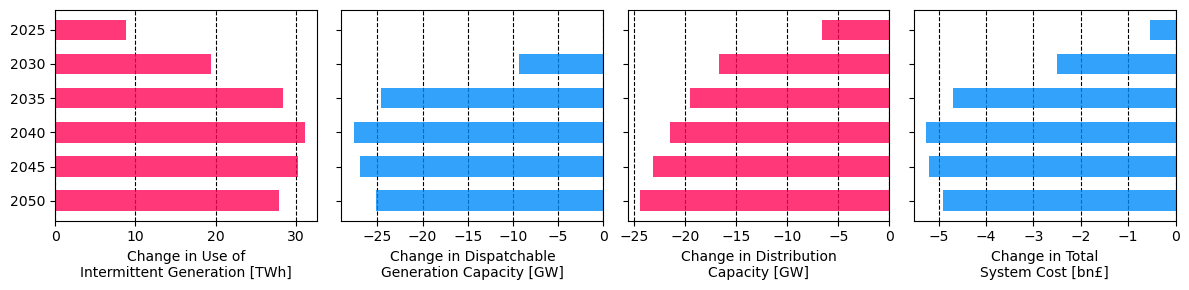

In [18]:
from itertools import cycle

with_text = False
with_partial = False
save = False

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

barh_kwargs = {
    "height": 0.6,
    "alpha": 0.8,
}

indexes = {
    "int": intermittent+"_energy",
    "cap": conventional+"_p_nom",
    # "tra": "transmission_s_nom",
    "tra": "transmission_s_nom",
    "dis": "distribution_p_nom",
}

plotted_quants = ["int", "cap", "dis", "cos"]
# plotted_quants = ["cos"]
for ax, name, color in zip(axs, plotted_quants, cycle([c1, c2])):

    if name == 'int': fac = 1e-6
    elif name == 'cos': fac = 1e-9
    else: fac = 1e-3

    df = data.groupby(level=1).sum()
    partial_df = partial_results[name].copy()

    if name in ["int", "cap"]:
        df = df.loc[indexes[name]].sum()
    elif name == 'cos':
        df = df.apply(lambda x: get_total_system_cost(*x.name), axis=0).mul(1/1.15)
    else:
        df = df.loc[indexes[name]]
    
    df = df.mul(fac)
    partial_df = partial_df.mul(fac)

    widths = []
    ls = []
    bases = []

    for year in sorted(df.index.get_level_values(1).unique().astype(int))[::-1]:
        year = str(year)
        year_df = df.loc[idx[:, year]]

        l, r = year_df.min(), year_df.max()
        width = r - l
        widths.append(width)
        ls.append(l)
        bases.append(year_df.loc["no flex"])


    for i, year in enumerate(sorted(df.index.get_level_values(1).unique().astype(int))[::-1]):

        year = str(year)
    
        year_df = df.loc[idx[:, year]]
        
        l, r = year_df.min(), year_df.max()
        width = r - l

        if name == "int":
            ax.barh(year, width, color=color, **barh_kwargs)
            
            if with_partial:
                partial_width = partial_df.loc[year] - l
                ax.plot(
                    [partial_width, partial_width],
                    [i - barh_kwargs['height'], i + barh_kwargs['height']],
                    color="k",
                    linewidth=2,
                    linestyle="dashed",
                    )

        else:
            ax.barh(year, -width, color=color, **barh_kwargs)

            if with_partial:
                partial_width = r - partial_df.loc[year]
                ax.plot(
                    [-partial_width, -partial_width],
                    [i - barh_kwargs['height'], i + barh_kwargs['height']],
                    color="k",
                    linewidth=2,
                    linestyle="dashed",
                    )


    if not with_text or name == "cos": continue

    for (i, year), w in zip(enumerate(sorted(df.index.get_level_values(1).unique().astype(int))[::-1]), widths):

        if name == "int": 
            ha = "left"
            mul = 1.
            unit = "TWh"
        else:
            ha = "right"
            mul = -1.
            unit = "GW"

        year = str(year)
        ax.text(
            mul * max(widths)*0.02,
            year,
            f"Base: {np.around(bases[i], decimals=2)} {unit}",
            va='center',
            ha=ha, 
            )


for ax in axs[1:]:
    ax.set_yticklabels("")

for ax in axs:
    ax.grid(axis="x", linestyle="dashed", color="k")
    ax.set_axisbelow(True)

ylabels = {
    'int': "Change in Use of\nIntermittent Generation [TWh]",
    'cap': "Change in Dispatchable\nGeneration Capacity [GW]",
    'tra': "Change in Transmission\nCapacity [GW]",
    'dis': "Change in Distribution\nCapacity [GW]",
    'cos': "Change in Total\nSystem Cost [bn£]"
}

for ax, l in zip(axs, plotted_quants):
    ax.set_xlabel(ylabels[l])

plt.tight_layout()

if save:
    plt.savefig(f"whole_system_change_{ll}_{scenario}.pdf")
plt.show()

In [1]:
import pypsa
from pathlib import Path
nr = pypsa.Network(Path.cwd().parent / "results" / "pypsa-fes" / "networks" / "elec_s_ec_lhnd__int-tank-ss-v2g_LW_2030_ev_1.0_heat_0.25.nc")
nf = pypsa.Network(Path.cwd().parent / "resources" / "pypsa-fes" / "networks" / "elec_s_ec_lhnd__int-tank-ss-v2g_LW_2030.nc")

INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2030_ev_1.0_heat_0.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [2]:
get_tank = lambda n: n.storage_units.loc[n.storage_units.carrier == "hot water tank"]
print(get_tank(nr)["p_nom"].sum())
print(get_tank(nf)["p_nom"].sum())

2646.169491356482
10584.677965425928
